# Swiss Tweet Votations

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## Data retrieving
Since we want to focus on one particular event, we don't need to work on the complete dataset. We download the tweets from the cluster to be able to work on them remotely.

In [35]:
# Download the dataset from Hadoop

import glob
from os.path import basename, splitext
import requests as rx
from urllib.request import urlretrieve
from time import sleep

swiss_tweet_url = 'http://iccluster060.iccluster.epfl.ch:50070/webhdfs/v1/datasets/swiss-tweet'
operation_list = '?op=LISTSTATUS'
operation_open = '?op=OPEN'

req = rx.get(swiss_tweet_url + operation_list)
if req.status_code != 200:
    raise Exception("Failed to load list of files")

remote_swiss_tweet_files = set(map(lambda f: f['pathSuffix'], req.json()['FileStatuses']['FileStatus']))
local_swiss_tweet_files = set(map(lambda f: basename(f), glob.glob('data/harvest3r_twitter_data_*.json')))

missing_swiss_tweet_files = remote_swiss_tweet_files - local_swiss_tweet_files
missing_index, missing_count = 0, len(missing_swiss_tweet_files)

if missing_count == 0:
    print("Your dataset is complete, nothing to download!")

for swiss_tweet_file in missing_swiss_tweet_files:
    missing_index += 1
    print("Downloading {} ({} of {} files)".format(swiss_tweet_file, missing_index, missing_count))
    
    frm = swiss_tweet_url + '/' + swiss_tweet_file + operation_open
    to = 'data/' + swiss_tweet_file
    
    urlretrieve(frm, to)
    sleep(1)

Your dataset is complete, nothing to download!


## Preprocessing: Filtering

As we only want tweets containing hashtags, we keep only those and save them so there are less tweets to process afterwards.

In [36]:
i = 0
datasets = glob.glob('data/harvest3r_twitter_data_*.json')
for datapath in datasets:
    i += 1
    print("Working on file {} of {}: {}".format(i, len(datasets), datapath))
    tweets = pd.DataFrame( pd.read_json(datapath)._source.tolist() )
    tagged_tweets = tweets.dropna(subset=['tags'])
    print("Amount of tagged tweets found: {}".format(tagged_tweets.size))
    taggedpath = 'data/tagged_' + splitext(basename(datapath))[0] + '.json'
    print("Tagged tweets written to: {}".format(taggedpath))
    tagged_tweets.to_json(taggedpath)

Working on file 1 of 302: data/harvest3r_twitter_data_07-05_0.json
Amount of tagged tweets found: 547391
Tagged tweets written to: data/tagged_harvest3r_twitter_data_07-05_0.json
Working on file 2 of 302: data/harvest3r_twitter_data_29-06_0.json
Amount of tagged tweets found: 351680
Tagged tweets written to: data/tagged_harvest3r_twitter_data_29-06_0.json
Working on file 3 of 302: data/harvest3r_twitter_data_27-01_0.json


KeyboardInterrupt: 

## Preprocessing: Exploration

First of all, we need to discover hashtags used for the votations. We begin our search by finding all tweets tagged #chvote, a popular hashtag when votations are around the corner. We will then count every other hashtags associated – in general, the subject of the votation is also in the hashtags.

In [37]:
# Save tweets with tag #chvote

i = 0
datasets = glob.glob('data/tagged_harvest3r_twitter_data_*.json')
for datapath in datasets:
    i += 1
    print("Working on file {} of {}: {}".format(i, len(datasets), datapath))
    tweets = pd.read_json(datapath)
    tweets['tags_str'] = tweets.tags.apply(lambda t: ':'.join(t))
    chvotes = tweets.select(lambda t: tweets.loc[t].tags_str.lower().find('chvote') != -1)
    print("Amount of #chvote found: {} / {}".format(chvotes.size, tweets.size))
    chvotepath = datapath.replace('tagged', 'chvote')
    print("#chvote written to: {}".format(chvotepath))
    chvotes.to_json(chvotepath)

Working on file 1 of 2: data/tagged_harvest3r_twitter_data_29-06_0.json
Amount of #chvote found: 0 / 356076
#chvote written to: data/chvote_harvest3r_twitter_data_29-06_0.json
Working on file 2 of 2: data/tagged_harvest3r_twitter_data_07-05_0.json
Amount of #chvote found: 560 / 554320
#chvote written to: data/chvote_harvest3r_twitter_data_07-05_0.json


In [39]:
# Aggregate tweets with tag #chvote in a DataFrame

i = 0
chvote_tweets = pd.DataFrame()
datasets = glob.glob('data/chvote_harvest3r_twitter_data_*.json')
for datapath in datasets:
    i += 1
    print("Working on file {} of {}: {}".format(i, len(datasets), datapath))
    tweets = pd.read_json(datapath)
    print("Amount of tweets with #chvote", )
    chvote_tweets = chvote_tweets.append(tweets, ignore_index=True)

Working on file 1 of 2: data/chvote_harvest3r_twitter_data_07-05_0.json
Amount of tweets with #chvote
Working on file 2 of 2: data/chvote_harvest3r_twitter_data_29-06_0.json
Amount of tweets with #chvote


In [40]:
# Save the tweets in a json file for distribution and reuse

chvote_tags = list()
for tags in chvote_tweets.tags:
    chvote_tags += [t.lower() for t in tags]

chvote_tags = pd.Series(chvote_tags)
chvote_tweets.to_json('data/tweets-chvote.json')

# Popular tags
chvote_tags.value_counts().head(10)

## Preprocessing: selecting tweets with given tags

We found a list of popular tags associated with the votations (more info on these in the README): "Abst16", "AVSplus", "LRens", "RBI". For each of those, we create a separate json file containing only those, once again to ease distribution and reuse – each generated file is less than 10MB.

In [44]:
i = 0
tags = ['abst16', 'avsplus', 'lrens', 'rbi']
tweets_by_tag = {}
for t in tags:
    tweets_by_tag[t] = pd.DataFrame()

datasets = glob.glob('data/tagged_harvest3r_twitter_data_*.json')
for datapath in datasets:
    i += 1
    print("Working on file {} of {}: {}".format(i, len(datasets), datapath))
    tweets = pd.read_json(datapath)
    tweets['tags_str'] = tweets.tags.apply(lambda t: ':'.join(t))
    for tag in tags:
        tweets_found = tweets.select(lambda t: tweets.loc[t].tags_str.lower().find(tag) != -1)
        tweets_by_tag[tag] = tweets_by_tag[tag].append(tweets_found, ignore_index=True)
        print("Amount of #{} found: {} / {}".format(tag, tweets_found.size, tweets.size))
    #chvotepath = datapath.replace('tagged', 'chvote')
    #print("#chvote written to: {}".format(chvotepath))
    #chvotes.to_json(chvotepath)

Working on file 1 of 302: data/tagged_harvest3r_twitter_data_14-08_0.json
Amount of #abst16 found: 0 / 1179428
Amount of #avsplus found: 0 / 1179428
Amount of #lrens found: 89 / 1179428
Amount of #rbi found: 1424 / 1179428
Working on file 2 of 302: data/tagged_harvest3r_twitter_data_23-02_0.json
Amount of #abst16 found: 884 / 459952
Amount of #avsplus found: 0 / 459952
Amount of #lrens found: 0 / 459952
Amount of #rbi found: 340 / 459952
Working on file 3 of 302: data/tagged_harvest3r_twitter_data_07-09_0.json
Amount of #abst16 found: 930 / 1709340
Amount of #avsplus found: 93 / 1709340
Amount of #lrens found: 2790 / 1709340
Amount of #rbi found: 1581 / 1709340
Working on file 4 of 302: data/tagged_harvest3r_twitter_data_18-08_0.json
Amount of #abst16 found: 279 / 1549287
Amount of #avsplus found: 372 / 1549287
Amount of #lrens found: 279 / 1549287
Amount of #rbi found: 2697 / 1549287
Working on file 5 of 302: data/tagged_harvest3r_twitter_data_15-10_0.json
Amount of #abst16 found: 188

Amount of #abst16 found: 63 / 131355
Amount of #avsplus found: 0 / 131355
Amount of #lrens found: 0 / 131355
Amount of #rbi found: 63 / 131355
Working on file 39 of 302: data/tagged_harvest3r_twitter_data_18-05_0.json
Amount of #abst16 found: 640 / 747920
Amount of #avsplus found: 0 / 747920
Amount of #lrens found: 0 / 747920
Amount of #rbi found: 800 / 747920
Working on file 40 of 302: data/tagged_harvest3r_twitter_data_08-08_0.json
Amount of #abst16 found: 0 / 1410561
Amount of #avsplus found: 0 / 1410561
Amount of #lrens found: 0 / 1410561
Amount of #rbi found: 1424 / 1410561
Working on file 41 of 302: data/tagged_harvest3r_twitter_data_27-10_0.json
Amount of #abst16 found: 1140 / 2652780
Amount of #avsplus found: 0 / 2652780
Amount of #lrens found: 0 / 2652780
Amount of #rbi found: 4845 / 2652780
Working on file 42 of 302: data/tagged_harvest3r_twitter_data_14-07_0.json
Amount of #abst16 found: 0 / 442288
Amount of #avsplus found: 0 / 442288
Amount of #lrens found: 0 / 442288
Amoun

Amount of #abst16 found: 868 / 462396
Amount of #avsplus found: 0 / 462396
Amount of #lrens found: 0 / 462396
Amount of #rbi found: 496 / 462396
Working on file 76 of 302: data/tagged_harvest3r_twitter_data_28-09_0.json
Amount of #abst16 found: 186 / 1638381
Amount of #avsplus found: 93 / 1638381
Amount of #lrens found: 93 / 1638381
Amount of #rbi found: 1302 / 1638381
Working on file 77 of 302: data/tagged_harvest3r_twitter_data_28-05_0.json
Amount of #abst16 found: 595 / 421770
Amount of #avsplus found: 0 / 421770
Amount of #lrens found: 0 / 421770
Amount of #rbi found: 765 / 421770
Working on file 78 of 302: data/tagged_harvest3r_twitter_data_31-08_0.json
Amount of #abst16 found: 1302 / 1622943
Amount of #avsplus found: 1488 / 1622943
Amount of #lrens found: 186 / 1622943
Amount of #rbi found: 837 / 1622943
Working on file 79 of 302: data/tagged_harvest3r_twitter_data_07-03_0.json
Amount of #abst16 found: 68 / 447508
Amount of #avsplus found: 0 / 447508
Amount of #lrens found: 0 / 4

Amount of #abst16 found: 0 / 513576
Amount of #avsplus found: 0 / 513576
Amount of #lrens found: 0 / 513576
Amount of #rbi found: 288 / 513576
Working on file 113 of 302: data/tagged_harvest3r_twitter_data_04-09_0.json
Amount of #abst16 found: 1116 / 1131810
Amount of #avsplus found: 0 / 1131810
Amount of #lrens found: 93 / 1131810
Amount of #rbi found: 2883 / 1131810
Working on file 114 of 302: data/tagged_harvest3r_twitter_data_18-02_0.json
Amount of #abst16 found: 938 / 465918
Amount of #avsplus found: 0 / 465918
Amount of #lrens found: 0 / 465918
Amount of #rbi found: 536 / 465918
Working on file 115 of 302: data/tagged_harvest3r_twitter_data_09-02_0.json
Amount of #abst16 found: 576 / 483712
Amount of #avsplus found: 0 / 483712
Amount of #lrens found: 0 / 483712
Amount of #rbi found: 448 / 483712
Working on file 116 of 302: data/tagged_harvest3r_twitter_data_10-02_0.json
Amount of #abst16 found: 704 / 387968
Amount of #avsplus found: 0 / 387968
Amount of #lrens found: 0 / 387968
A

Amount of #abst16 found: 285 / 1614145
Amount of #avsplus found: 0 / 1614145
Amount of #lrens found: 95 / 1614145
Amount of #rbi found: 2280 / 1614145
Working on file 150 of 302: data/tagged_harvest3r_twitter_data_31-03_0.json
Amount of #abst16 found: 0 / 452128
Amount of #avsplus found: 0 / 452128
Amount of #lrens found: 0 / 452128
Amount of #rbi found: 568 / 452128
Working on file 151 of 302: data/tagged_harvest3r_twitter_data_10-08_0.json
Amount of #abst16 found: 0 / 1534805
Amount of #avsplus found: 0 / 1534805
Amount of #lrens found: 0 / 1534805
Amount of #rbi found: 1424 / 1534805
Working on file 152 of 302: data/tagged_harvest3r_twitter_data_06-01_0.json
Amount of #abst16 found: 63 / 328923
Amount of #avsplus found: 0 / 328923
Amount of #lrens found: 0 / 328923
Amount of #rbi found: 630 / 328923
Working on file 153 of 302: data/tagged_harvest3r_twitter_data_20-08_0.json
Amount of #abst16 found: 930 / 1216440
Amount of #avsplus found: 465 / 1216440
Amount of #lrens found: 186 / 1

Amount of #abst16 found: 1428 / 326400
Amount of #avsplus found: 0 / 326400
Amount of #lrens found: 0 / 326400
Amount of #rbi found: 884 / 326400
Working on file 187 of 302: data/tagged_harvest3r_twitter_data_18-04_0.json
Amount of #abst16 found: 71 / 388512
Amount of #avsplus found: 0 / 388512
Amount of #lrens found: 0 / 388512
Amount of #rbi found: 426 / 388512
Working on file 188 of 302: data/tagged_harvest3r_twitter_data_27-01_0.json
Amount of #abst16 found: 558 / 530844
Amount of #avsplus found: 0 / 530844
Amount of #lrens found: 0 / 530844
Amount of #rbi found: 186 / 530844
Working on file 189 of 302: data/tagged_harvest3r_twitter_data_07-06_0.json
Amount of #abst16 found: 405 / 577125
Amount of #avsplus found: 0 / 577125
Amount of #lrens found: 0 / 577125
Amount of #rbi found: 810 / 577125
Working on file 190 of 302: data/tagged_harvest3r_twitter_data_31-05_0.json
Amount of #abst16 found: 1020 / 582250
Amount of #avsplus found: 0 / 582250
Amount of #lrens found: 85 / 582250
Amou

Amount of #abst16 found: 0 / 455949
Amount of #avsplus found: 0 / 455949
Amount of #lrens found: 0 / 455949
Amount of #rbi found: 162 / 455949
Working on file 224 of 302: data/tagged_harvest3r_twitter_data_23-01_0.json
Amount of #abst16 found: 124 / 211110
Amount of #avsplus found: 0 / 211110
Amount of #lrens found: 0 / 211110
Amount of #rbi found: 434 / 211110
Working on file 225 of 302: data/tagged_harvest3r_twitter_data_27-09_0.json
Amount of #abst16 found: 558 / 1648146
Amount of #avsplus found: 93 / 1648146
Amount of #lrens found: 279 / 1648146
Amount of #rbi found: 1581 / 1648146
Working on file 226 of 302: data/tagged_harvest3r_twitter_data_06-03_0.json
Amount of #abst16 found: 68 / 330004
Amount of #avsplus found: 0 / 330004
Amount of #lrens found: 0 / 330004
Amount of #rbi found: 680 / 330004
Working on file 227 of 302: data/tagged_harvest3r_twitter_data_29-09_0.json
Amount of #abst16 found: 0 / 1656981
Amount of #avsplus found: 0 / 1656981
Amount of #lrens found: 279 / 165698

Amount of #abst16 found: 760 / 2400935
Amount of #avsplus found: 0 / 2400935
Amount of #lrens found: 0 / 2400935
Amount of #rbi found: 2850 / 2400935
Working on file 261 of 302: data/tagged_harvest3r_twitter_data_12-07_0.json
Amount of #abst16 found: 0 / 408496
Amount of #avsplus found: 0 / 408496
Amount of #lrens found: 0 / 408496
Amount of #rbi found: 440 / 408496
Working on file 262 of 302: data/tagged_harvest3r_twitter_data_02-08_0.json
Amount of #abst16 found: 0 / 739857
Amount of #avsplus found: 0 / 739857
Amount of #lrens found: 0 / 739857
Amount of #rbi found: 623 / 739857
Working on file 263 of 302: data/tagged_harvest3r_twitter_data_03-06_0.json
Amount of #abst16 found: 510 / 647530
Amount of #avsplus found: 0 / 647530
Amount of #lrens found: 0 / 647530
Amount of #rbi found: 1190 / 647530
Working on file 264 of 302: data/tagged_harvest3r_twitter_data_04-02_0.json
Amount of #abst16 found: 448 / 146944
Amount of #avsplus found: 0 / 146944
Amount of #lrens found: 0 / 146944
Amou

Amount of #abst16 found: 0 / 440792
Amount of #avsplus found: 0 / 440792
Amount of #lrens found: 0 / 440792
Amount of #rbi found: 440 / 440792
Working on file 298 of 302: data/tagged_harvest3r_twitter_data_12-04_0.json
Amount of #abst16 found: 284 / 526536
Amount of #avsplus found: 0 / 526536
Amount of #lrens found: 0 / 526536
Amount of #rbi found: 1065 / 526536
Working on file 299 of 302: data/tagged_harvest3r_twitter_data_24-07_0.json
Amount of #abst16 found: 0 / 1041972
Amount of #avsplus found: 0 / 1041972
Amount of #lrens found: 0 / 1041972
Amount of #rbi found: 2325 / 1041972
Working on file 300 of 302: data/tagged_harvest3r_twitter_data_29-03_0.json
Amount of #abst16 found: 142 / 478398
Amount of #avsplus found: 0 / 478398
Amount of #lrens found: 142 / 478398
Amount of #rbi found: 568 / 478398
Working on file 301 of 302: data/tagged_harvest3r_twitter_data_02-04_0.json
Amount of #abst16 found: 426 / 350243
Amount of #avsplus found: 0 / 350243
Amount of #lrens found: 0 / 350243
Am

In [51]:
for tag in tweets_by_tag:
    tagpath = "data/tweets-{}.json".format(tag)
    print("Writting {} tweets to {}".format(tweets_by_tag[tag].size, tagpath))
    tweets_by_tag[tag].to_json(tagpath)

Writting 352735 tweets to data/tweets-abst16.json
Writting 33915 tweets to data/tweets-avsplus.json
Writting 49020 tweets to data/tweets-lrens.json
Writting 379715 tweets to data/tweets-rbi.json


## Data exploration

There, we look at an example a votation (LRens) to get a grip of the kind of data we have and do some basic tests/exploration around it.

In [47]:
tweets = pd.read_json('data/tweets-lrens.json')
tweets.columns

Index(['author_avatar_img', 'author_gender', 'author_handle', 'author_link',
       'author_name', 'author_user_id', 'bucket', 'canonical', 'comments',
       'date_found', 'dislikes', 'domain', 'geo_city', 'geo_country',
       'geo_featurename', 'geo_location', 'geo_location_id', 'geo_method',
       'geo_name', 'geo_name_id', 'geo_point', 'geo_state', 'hashcode',
       'image_src', 'index_method', 'lang', 'last_updated', 'likes', 'links',
       'lower_tags', 'main', 'main_authoritative', 'main_checksum',
       'main_format', 'main_length', 'mentions', 'metadata_score',
       'metadata_updates', 'permalink', 'published', 'replied',
       'replied_profile_link', 'replied_profile_title', 'resource',
       'sentiment', 'sequence', 'sequence_range', 'shared',
       'shared_profile_link', 'shared_profile_title', 'shares', 'site',
       'source_assigned_tags', 'source_content_checksum',
       'source_content_length', 'source_created', 'source_date_found',
       'source_descriptio

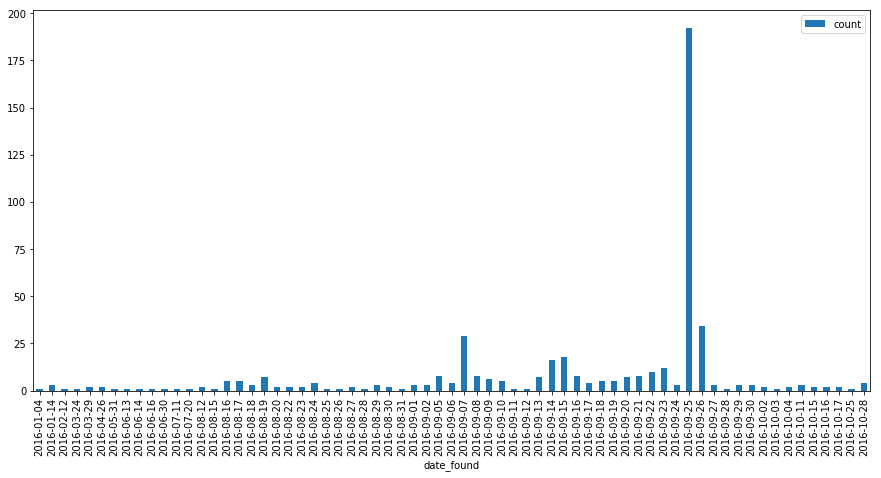

In [51]:
# Here, a time plot of the number of tweets mentionning #LRens (votation of the 25 sept 2016)

from datetime import datetime

date_parser = lambda d: datetime.strptime(d[:10], "%Y-%m-%d").date()
tweets['date_found'] = tweets['date_found'].apply(date_parser)
counts = pd.DataFrame({"count": tweets.groupby('date_found').size()})
plt.figure()
counts.plot(kind='bar', figsize=(15, 7))

In [37]:
# Dumb test to see the relevance of a dirt simple classifier (to classify tweets into "will vote YES/NO")

noes = ["non", "nein", "no"] 
yess = ['oui', 'ya', 'yes']

no_tweets = []
yes_tweets = []

for i,c in df.iterrows():
    comparable = c['main'].lower().split()
    if any([no in comparable for no in noes]):
        print("NO:  ", c['main'], c['tags'])
        no_tweets.append(c['main'])
    if any([yes in comparable for yes in yess]):
        print("YES: ", c['main'], c['tags'])
        yes_tweets.append(c['main'])

NO:   Lundi, lors d'une CP, notre président nous a représenté en disant NON à une loi qui falicitera la tâche des terroristes ! #CHVote #NONLRens ['CHVote', 'NONLRens']
NO:   @ForumRTS Est-ce une assertion? Est-ce (l'idéalisme) un mal? ;-) Est-ce que l'idéalisme est la raison de notre NON à la #LRens? Non! ['LRens']
YES:  Oui l'état doit avoir les moyens de protéger ses citoyens. Mais ps via de l'espionnage de masse... #rtsinfrarouge #LRens ['LRens', 'rtsinfrarouge']
NO:   Enfin, incertains sur la #LRens, le @PSSuisse : 41% de oui (-20%), 48% de non (+19%). #CHvote #25sept ['25sept', 'CHvote', 'LRens']
YES:  Enfin, incertains sur la #LRens, le @PSSuisse : 41% de oui (-20%), 48% de non (+19%). #CHvote #25sept ['25sept', 'CHvote', 'LRens']
YES:  AVS+ OUI le 25 septembre ! #ahvplusja #ahvplus #geneve #lrens #économieverte #25septembre2016 #votations ['25septembre2016', 'ahvplus', 'ahvplusja', 'geneve', 'lrens', 'votations', 'économieverte']
YES:  Si toi aussi tu souhaites que pendant ton 

### The exploration that made us a bit skeptical of basing our analysis on the sentiment score... 

First we can see that there are less than 5% of the tweets that aren't classified as "NEUTRAL" which is quite a low number to base our observations on (especially if there isn't much data to begin with). Then, by looking at the tweets we have, it's easy to see – as humans – that the subject is polarizing and there are subtleties and references to History that are hard to pickup by a computer. Example:
  "@benoitgaillard ouais, on a vu, le sujet des écoutes allemandes a été fort bien traité avant la votation sur #LRens -.-"

In [57]:
print(tweets['sentiment'].value_counts())

for idx, t in tweets[tweets['sentiment'] == 'NEUTRAL'].iterrows():
    print(t['main'])

NEUTRAL     450
POSITIVE     12
NEGATIVE      5
Name: sentiment, dtype: int64
@RTSinfrarouge quand @desmeulesj déboite @cedricwermuth ! #LRENSpic.twitter.com/5QMwpAzhyz
Second sondage SSR: vers un rejet d'#AVSPlus et #EconomieVerte. La #LRens convainc. #CHvote http://ow.ly/kO73304cZJN pic.twitter.com/YEpWPjrGS1
C'est parti pour le débat de #RTSinfrarouge sur la #LRens. A suivre en direct sur #RTSUn #chvote @RTSinfo
25 oct - Swiss Tech Talks Lausanne : #LRens et sécurité des données http://cominm.ag/2di0AIN 
Bah, ils peuvent compter sur la #LRens pour compenser avantageusement les détectives... Privée de détectives, la Suva assure qu'elle va perdre des millions http://www.rts.ch/info/suisse/8124306-privee-de-detectives-la-suva-assure-qu-elle-va-perdre-des-millions.html …
Bah, ils peuvent compter sur la #LRens pour compenser avantageusement les détectives... Privée de détectives, la Suva assure qu'elle va perdre des millions http://www.rts.ch/info/suisse/8124306-privee-de-detectives-la-s